<a href="https://colab.research.google.com/github/Adi8885/RecurrentNets/blob/master/Tweet_classification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import xgboost as xgb
from sklearn.metrics import classification_report , f1_score , accuracy_score , confusion_matrix
#import skopt
import time
from transformers import BertModel , BertTokenizer , BertForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import logging

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data = pd.read_csv('train.csv' , low_memory = False)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
data.groupby('target')['id'].count()

target
0    4342
1    3271
Name: id, dtype: int64

In [0]:
data = data[['text','target']]

In [0]:
data['word_count'] = data['text'].apply(lambda x: len(str(x).split(" ")))

In [13]:
data['word_count'].describe(percentiles = [0.5 ,0.75 , 0.9 , 0.95 , 0.98 , 0.99])

count    7613.000000
mean       14.928937
std         5.782770
min         1.000000
50%        15.000000
75%        19.000000
90%        23.000000
95%        24.000000
98%        26.000000
99%        27.000000
max        54.000000
Name: word_count, dtype: float64

In [0]:
X = data.text.str.lower()
Y = data.target

In [15]:
word_dict = {}
word_ctr = 0
for i in X.index:
  sentence = X.loc[i].split(' ')
  for j in sentence:
    if word_dict.get(j,0) == 0 :
      word_dict[word_ctr] = j
      word_ctr+=1
    else:
      pass

len(word_dict)


113654

In [0]:
#stop = stopwords.words('english')

In [0]:
#vectorizer = TfidfVectorizer(stop_words = stop)
#tfidf_matrix = vectorizer.fit_transform(X)
#tfidf_matrix

In [19]:
"""
def objective_function_w(params):

    max_depth, n_estimators = params
    print('max_depth :{}'.format(max_depth))
    print('n_estimators :{}'.format(n_estimators))
    xgb_clf = xgb.XGBClassifier(max_depth = max_depth , 
                              n_estimators = n_estimators , 
                              random_state =7,
                              n_jobs = -1)
            
    fitted_model = xgb_clf.fit(x_train, y_train)

    y_pred = xgb_clf.predict(x_val)
        
    metric = f1_score(y_true = y_val, y_pred = y_pred)
            
    if metric == None:
      return 0
    else:
      return -metric 
"""

"\ndef objective_function_w(params):\n\n    max_depth, n_estimators = params\n    print('max_depth :{}'.format(max_depth))\n    print('n_estimators :{}'.format(n_estimators))\n    xgb_clf = xgb.XGBClassifier(max_depth = max_depth , \n                              n_estimators = n_estimators , \n                              random_state =7,\n                              n_jobs = -1)\n            \n    fitted_model = xgb_clf.fit(x_train, y_train)\n\n    y_pred = xgb_clf.predict(x_val)\n        \n    metric = f1_score(y_true = y_val, y_pred = y_pred)\n            \n    if metric == None:\n      return 0\n    else:\n      return -metric \n"

In [0]:
#space = [(3, 15),(50, 100)]

In [0]:
#start_time = time.time()
#res = skopt.gp_minimize(objective_function_w, space , n_calls=51, n_random_starts=11 , verbose=True)
#print('time taken to hyperopt : {}'.format(round(int(time.time() -start_time), 0)))

In [0]:
max_seq_length = 64
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased' , max_len = max_seq_length)
model = BertModel.from_pretrained('bert-large-uncased' , output_hidden_states=True)

In [73]:
embeddings_matrix =  np.zeros((X.shape[0] , 1024))
embeddings_matrix.shape

(7613, 1024)

In [74]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('CUDA available using GPU')
else :
   device = torch.device('cpu')
   print('CUDA NOT available using CPU')

CUDA available using GPU


In [75]:
model = model.to(device)
print_every = 100
record_ctr = 0
start_time_loop = time.time()
start_time = start_time_loop
time_list = []
for i in X.index:
  sentence = X.loc[i]
  input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)[:max_seq_length]).unsqueeze(0)
  outputs = model(input_ids.to(device))
  last_layer = outputs[2][12][0][0]
  layer_11 = outputs[2][11][0][0]
  layer_10 = outputs[2][10][0][0]
  layer_9 = outputs[2][9][0][0]

  final_embedding = last_layer + layer_11 + layer_10 + layer_9

  embeddings_matrix[i]+=final_embedding.cpu().detach().numpy()

  if record_ctr % print_every == 0 :
    print('index {} / {} , {}'.format(i , X.shape[0] , time.time() - start_time))
    time_list.append(time.time() - start_time)
    start_time = time.time()

  record_ctr+=1

try:
  np.save('embeddings_matrix' , arr = embeddings_matrix , allow_pickle=True)
  print('Saved matrix locally')
except:
  print('ERROR saving embeddings')
  print('time taken to generate embeddings : {}'.format(time.time() - start_time_loop))

index 0 / 7613 , 0.04597616195678711
index 100 / 7613 , 3.8083250522613525
index 200 / 7613 , 3.7330832481384277
index 300 / 7613 , 3.7903568744659424
index 400 / 7613 , 3.7696237564086914
index 500 / 7613 , 3.919287919998169
index 600 / 7613 , 3.809907913208008
index 700 / 7613 , 3.767367124557495
index 800 / 7613 , 3.8602089881896973
index 900 / 7613 , 3.7861969470977783
index 1000 / 7613 , 3.831881523132324
index 1100 / 7613 , 3.7365567684173584
index 1200 / 7613 , 3.7784335613250732
index 1300 / 7613 , 3.950472116470337
index 1400 / 7613 , 4.153333425521851
index 1500 / 7613 , 3.807671070098877
index 1600 / 7613 , 4.038038492202759
index 1700 / 7613 , 3.7569336891174316
index 1800 / 7613 , 3.8387670516967773
index 1900 / 7613 , 3.7633538246154785
index 2000 / 7613 , 3.83243989944458
index 2100 / 7613 , 3.81644868850708
index 2200 / 7613 , 3.9596896171569824
index 2300 / 7613 , 3.7657554149627686
index 2400 / 7613 , 3.714146375656128
index 2500 / 7613 , 3.7513177394866943
index 2600

In [79]:
x_train, x_val, y_train, y_val = train_test_split(embeddings_matrix, Y, test_size=0.15, random_state=7)
print('x_train :{}'.format(x_train.shape))
print('y_train :{}'.format(y_train.shape))
print('x_val :{}'.format(x_val.shape))
print('y_val :{}'.format(y_val.shape))

x_train :(6471, 1024)
y_train :(6471,)
x_val :(1142, 1024)
y_val :(1142,)


In [80]:
final_embedding.shape

torch.Size([1024])

In [81]:
batch_size = 512
#Convert input data to tensors
x_train_data_tensor = torch.tensor(x_train)
y_train_data_tensor = torch.tensor(y_train.values)
print(x_train_data_tensor.shape)

#Convert tensors to type Dataset
train_dataset = torch.utils.data.TensorDataset(x_train_data_tensor ,y_train_data_tensor)
print(type(train_dataset))

#Convert datsets to Dataloader for loading batches
train_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(type(train_dataset))

torch.save(train_dataset, 'train_dataset.dataloader')

torch.Size([6471, 1024])
<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [82]:
#Convert input data to tensors
x_val_data_tensor = torch.tensor(x_val)
y_val_data_tensor = torch.tensor(y_val.values)
print(x_val_data_tensor.shape)

#Convert tensors to type Dataset
val_dataset = torch.utils.data.TensorDataset(x_val_data_tensor ,y_val_data_tensor)
print(type(val_dataset))

#Convert datsets to Dataloader for loading batches
val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
type(val_dataset)

torch.save(val_dataset, 'val_dataset.dataloader')

torch.Size([1142, 1024])
<class 'torch.utils.data.dataset.TensorDataset'>


In [0]:
output_size = len(Y.unique())
batch_size = batch_size
drop_out_probability = 0.33
input_size = 1024
hidden_size = input_size

In [0]:
class BERT_Classification(nn.Module):
    def __init__(self , input_size , hidden_size , output_size):
        super(BERT_Classification ,self).__init__()
        
        self.fc_input_size = input_size
        self.fc_hidden_size = hidden_size
        self.fc_output_size = output_size
        
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(in_features = input_size , out_features = hidden_size)
        self.fc2 = nn.Linear(in_features = input_size , out_features = hidden_size)
        self.dropout = nn.Dropout(p = 0.33)
        
        # Output layer, 10 units - one for each digit
        self.out = nn.Linear(in_features = hidden_size , out_features = output_size)
        
        
    def forward(self,x):
        
        #Pass output of BERT through Fully connected layer
        x = self.fc1(x)
        x = torch.tanh(x)

        x = self.fc2(x)
        x = torch.tanh(x)

        x = self.dropout(x)
        
        #Output layer
        x = self.out(x)
        
        return x
    
bert_classification = BERT_Classification(input_size = input_size 
                            , hidden_size = input_size 
                            , output_size = output_size )

bert_classification = bert_classification.double()

In [85]:
epochs = 10
loss_fn = F.cross_entropy

learning_rate = 0.001

optimizer = torch.optim.Adam(bert_classification.parameters(), lr = learning_rate)
print_every = 100
bert_classification.to(device)


# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience_ctr = 0
patience = 5
    
for epoch in range(0,epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    batch = 0
    #loss = 0
    start_time = time.time()
    bert_classification.train()
    for i in range(0,len(train_dataset)) :
        x, y = next(iter(train_dataset))
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = bert_classification(x)
        
        #y_pred = y_pred.unsqueeze(0)
        loss = loss_fn(y_pred , y)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (batch % print_every == 0):
            print('epoch : {} \t batch number : {} \t train loss : {}'.format(epoch, batch,loss.item()))
            
        batch +=1

        #Calculate Validation loss
    val_acc = 0
    bert_classification.eval()
    for j in val_dataset :
        x_v, y_v = next(iter(val_dataset))
        x_v = x_v.to(device)
        y_v = y_v.to(device)
        
        y_pred = bert_classification(x_v)
        loss = loss_fn(y_pred , y_v)
        
        valid_losses.append(loss.item())
    
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    #Early stopping
    if valid_loss > train_loss:
        patience_ctr +=1
        print('patience_ctr : {}'.format(patience_ctr))
        if patience_ctr >= patience:
            print('early stoppping since valid_loss > train_loss')
            break
    else :
        patience_ctr = 0
    
    epoch_len = len(str(epochs))
    print('epoch : {}\t train_loss :{}\t validation loss : {}\n'.format(epoch , train_loss , valid_loss))
    
            
    print('epoch : {} \t train loss : {} \t time required : {}'.format(epoch, loss.item(),(time.time() - start_time)))

epoch : 0 	 batch number : 0 	 train loss : 0.7218916154026157
epoch : 0	 train_loss :1.7148826930910739	 validation loss : 0.7505196442914227

epoch : 0 	 train loss : 0.7543187194902152 	 time required : 0.14241242408752441
epoch : 1 	 batch number : 0 	 train loss : 0.7489626884167778
epoch : 1	 train_loss :0.7421361936357826	 validation loss : 0.6723375562515951

epoch : 1 	 train loss : 0.6775516088679728 	 time required : 0.13022685050964355
epoch : 2 	 batch number : 0 	 train loss : 0.6787169280191679
epoch : 2	 train_loss :0.6737358352438438	 validation loss : 0.6198444259243683

epoch : 2 	 train loss : 0.620100019866864 	 time required : 0.1421968936920166
epoch : 3 	 batch number : 0 	 train loss : 0.6306895154327397
epoch : 3	 train_loss :0.558231393459889	 validation loss : 0.5216853116171739

epoch : 3 	 train loss : 0.5279248726900445 	 time required : 0.14907407760620117
epoch : 4 	 batch number : 0 	 train loss : 0.49183796293813503
patience_ctr : 1
epoch : 4	 train_l

In [86]:
st_time = time.time()
ctr = 0
print_every = 5
bert_classification = bert_classification.double()
bert_classification = bert_classification.to(device)
bert_classification = bert_classification.eval()
for j in val_dataset :
    x_v, y_v = next(iter(val_dataset))
    x_v = x_v.to(device)
    #y_v = y_v.to(device)
   
    op = bert_classification(x_v)
    op = torch.argmax(torch.sigmoid(op), dim = 1)
    if ctr == 0:
        y_pred = op
        y_actual = y_v
    else:
        y_pred = torch.cat((y_pred , op))
        y_actual = torch.cat((y_actual , y_v))
   
    ctr += 1
   
    if ctr % print_every == 0:
        print(ctr)
print('time taken for prediction :{} seconds'.format(time.time() - st_time ))

time taken for prediction :0.030162572860717773 seconds


              precision    recall  f1-score   support

           0       0.79      0.88      0.83       854
           1       0.83      0.71      0.76       682

    accuracy                           0.81      1536
   macro avg       0.81      0.80      0.80      1536
weighted avg       0.81      0.81      0.80      1536

accuracy : 0.8053385416666666
[[754 100]
 [199 483]]


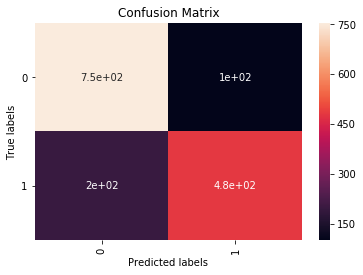

In [87]:
def my_classification_report(y_actual , y_predicted):
   
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_predicted)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    print(conf_mat)
    #plt.figure(figsize=(20,20))
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    #ax.xaxis.set_ticklabels(list(label_encoder.classes_))
    #ax.yaxis.set_ticklabels(list(label_encoder.classes_))
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    #plt.savefig('conf_matrix.png')
    plt.show()

y_actual = y_actual.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
my_classification_report(y_actual = y_actual , y_predicted = y_pred)